In [16]:
import numpy as np
import pydub
import matplotlib.pyplot as plt

In [32]:
path = "./songs/epic.mp3"
sound = pydub.AudioSegment.from_mp3(path)
song = np.array(sound.get_array_of_samples())

if sound.channels == 2:
        song = song.reshape((-1, 2))

size = song.shape[0]
chunk_size = 4000 #4kHz is best for bins
sampled_chunk_size = int(size/chunk_size)

sampled = np.zeros(shape=(sampled_chunk_size, chunk_size), dtype=np.complex_)

for i in range(sampled_chunk_size):
    time_variations = np.zeros(chunk_size, dtype=np.complex_)

    for j in range(chunk_size):
        time_variations[j] = complex(song[i * chunk_size + 1][0], 0)
#         print(time_variations[j])
        
    sampled[i] = np.fft.fft(time_variations)
# print(sampled)
# plt.plot(sampled[:500, :])
# plt.show()

In [ ]:
for i in sampled:
    for j in i:
        print(j.real)

-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0

-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0

-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0

-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
-4328000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
-6.327450147516763e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.5250668925055325e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.550949962238331e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.603485090605683e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.353916065922342e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.051306171370865e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.499163370440544e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.576863718551479e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.879956510712502e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.97131869905578e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.77450678930674e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.473188095261222e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.602859543298031e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.157413374864696e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.283163280011357e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.496500431396453e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.447089196776881e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.628989470178843e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.436412485114957e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.115082534

-3.642243954248313e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2045956027991225e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.528480183116743e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4403570637890033e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.184419497266016e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.1874724219369624e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1015966371711623e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5550867739120745e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.056545492065405e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.363527388773333e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.841982225104362e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0227367896294809e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.043044096122402e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7584315332046971e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0294517752241798e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.57012919779411e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.603099261199294e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0654541843893258e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5197721283221501e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
-4.385012168344072e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.5301425220989107e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.520997215577614e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.863013997185965e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.433556359089164e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.7319654576386065e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.2332791344473615e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.319895085505322e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.814815949820566e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.481677933260575e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.932111847075923e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.176333087649693e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.120303414326293e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.766960760539488e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.52947629613747e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.130993318504039e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.72089533776175e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.921815042278943e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.719351170224192e-13
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.151547261699664e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.544212741237869e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8700154946632055e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.256597917881511e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.4442791550393895e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.247964407196493e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.8604201298808526e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2301187326858578e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.5162134037389933e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.367735697632141e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.592702199350034e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.3593248161337485e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.565577868928645e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.9631945799652056e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.5618743001213968e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.094899120042845e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.975667564771796e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.912982698667162e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.5336540370906406e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1

0.0
0.0
0.0
0.0
0.0
0.0
8.732905128146357e-15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7115464795832625e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.813789785260867e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3512335567635882e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0122301007094934e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.365250936760017e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.674782789818965e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.8509137253880666e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3974867126862797e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.056123704753114e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0084682320437608e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6361325840244273e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.889967998038305e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4461767948627774e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2414318216155313e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5059383509682346e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5953642641698145e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.931190693957576e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4976058336571012e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
2.6110508528105395e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.6859323187881357e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9680919225142038e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.3345218189417828e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7197464304762175e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.42413391313562e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9063962649978575e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6828000694109477e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1689140478035693e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4595860064911364e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2761671259244e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.895626700023118e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4544055851685094e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2491603029235445e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.1559096150169975e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.6727291507382e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2670947208837654e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5084071194499558e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0751385116645612e-12
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
8.133664381760048e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0606882239576587e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.996344856507397e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.673091041698573e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3371272729732248e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.401978982412163e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.052922151621176e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2685180283809673e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.509522394441781e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3536244765965973e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.681843631201585e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.80021310750073e-15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.338615494413462e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3708719793056146e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.974610936713391e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.1151659639470982e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.563487562474957e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.159503634608753e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3889586784429774e-12
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.462234069961275e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.179728193471778e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.416328276615686e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.47242976126913e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.0004399149647016e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.157213048246965e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1653503386350593e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.55888372539277e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.445454506530465e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.754145498225647e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.864780281244103e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1515579962692475e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.695711220282919e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.300622650394936e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.53276107361889e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.583628674250617e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1382904561472223e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.827403938061541e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1050126157511585e-13
0.0
0.0
0.0
0.0
0.0
0.0
0

-2.0148336613643136e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0650091860704025e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.1341849939029e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.718389681392003e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.101913315659423e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4723026314923677e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2102257944659991e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4218233961612485e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7919273849840572e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.2616678160838464e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.969221307510695e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3809908755699469e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.815502632103054e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.878946044036708e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.4513320155458848e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5851386714757908e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.266699474326281e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9837544148567386e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.6806723890970825e-12
0.0
0.0
0.0
0.0
0.0
0.

-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.40453435

-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.40453435

-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.404534358275991e-10
-1.40453435

0.0
0.0
0.0
-3.2296163820732334e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.439774934435253e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2455641382092159e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7018113017383973e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2152126503091712e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.7389954933241023e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.012909043893948e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1979256117744837e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6558629328336912e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2605103588977099e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.282564001481036e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0243298801731971e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.153526603042197e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6130012240015746e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.302802018343441e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.8560551721886667e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1119682277348648e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.572848597922116e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.342452979454234e-12
0.0
0.0
0.0
0.0
0

0.0
1.5527208153767915e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.939132333018293e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.415176251114519e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.489006107538935e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0749156011180367e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.6340150784041656e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.706439057910822e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.264779634274824e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.638666626855873e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.161917797164196e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7250133713109918e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.219052587841073e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.681877042697493e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2599887523601953e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.827779180490149e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.23406381379089e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.300882334672602e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.59502578944883e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.371619521540174e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9450

0.0
0.0
0.0
1.1748396373883607e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4791074141234436e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.3329785089023992e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0493201339018355e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.2525571483223626e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.32649822602985e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4225366639821992e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.293302696936986e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0884341092455552e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.71054475175873e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5959425365198487e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3698128411126088e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.256292175330306e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1249524007077412e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.20406551697405e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.320462270435153e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2216209110347223e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1591904839037383e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7288281204893188e-13
0.0
0.0
0.0
0.0
0.0

0.0
0.0
2.1562129859376e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0403718632255306e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.501310765377445e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.876669880144112e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.316052002196044e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7288211783542862e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.768773517087377e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4818991955779433e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8961694951013578e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.591362917454136e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.350170105117423e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4908347706519975e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4620255410131472e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9161423037473665e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.873482677012022e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.621384159183261e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2057618090788051e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4416323773324308e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9366466996981687e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.1632459732477e-13
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3048962469285388e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.209065869995154e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4142249756022444e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0984821353673962e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5351955265873795e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.008602754577273e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.7390338152961544e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.5306043362474654e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2316685911035616e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
11660000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.483705836034895e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.08931707090913e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.285935770030078e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0952369676750605e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.126849244233784e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.639211282258505e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2129253665852263e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.4409995451811484e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.750280197152138e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.03074156353805

0.0
0.0
0.0
0.0
3.672377216303101e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.1326821096312996e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.1541749866390475e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.727631294193084e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.784782495803364e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.556418691164228e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.097463806654077e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.1891507465568323e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.863422693402144e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4443414450400177e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0634069685176364e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2229901510240295e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.962864716535771e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8856961047771196e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.335743051664738e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0303909786705624e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.255811424721128e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.029746936558765e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.757471226966368e-11
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
1.8642841294672876e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4252818706773092e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.638107619161918e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6236797754326112e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.293540964939198e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8138571095750874e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4763077684095702e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.806945984478844e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.023571838107266e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7602826612979232e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.530560041969233e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.986599377734498e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.329716407776178e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.86733396473572e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7031402299909021e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.588472696254732e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.17853259256678e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0801751072055236e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1840449268015579e-12
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.4123559792134627e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.7684378543085164e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.748784469924985e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.119925392394606e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.802045952342815e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.789462827735553e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.5413221621996625e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.525339328326248e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3374744014741535e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5924414388942053e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.3422134069150487e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.329036117021097e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5289896850137477e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.407551054140748e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5997741794323807e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.1659042144080707e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.154888629211592e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6991974396175795e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.24294039865344

0.0
-3.89481167069611e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.053120980293197e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.053120980293207e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.89481167069611e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.934735239599556e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.44806328348197e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.368546136285403e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.658022675961383e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.854856554912727e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.974706141289161e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.843630084557886e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.48422943608596e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.261986637008103e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.8147907629060925e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.0148036301567836e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0240606828652563e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.979531345637436e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.864223694151844e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.774534287043682e-12
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
-3.16590421440807e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5997741794323804e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4075510541407472e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5289896850137505e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.329036117021096e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.342213406915051e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5924414388942081e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3374744014741539e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.525339328326245e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.541322162199662e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.78946282773555e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8020459523428173e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1199253923946133e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.74878446992498e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.76843785430852e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.4123559792134603e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.042182562980359e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.70118304046842e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.005963960650141e-12
0.0
0.0
0.0
0

0.0
-9.783661057999022e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.9387139147123145e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.0052462856896554e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2852743542997062e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.138231752667914e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.014835231382284e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4490009599223547e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1775220720740994e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2376379178473567e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.103723847284162e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0488841907551226e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9913925284940908e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1930492443405325e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0713970208599943e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0808071273731033e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5620113720210566e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.796632708484748e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1511447825871752e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.040992666703035e-12
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
-1.866643813346952e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.114574777812514e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.682776235793804e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.814063226708069e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.261993515017921e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.888400801252251e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.413117205857138e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1471247209218677e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.782286744047847e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2395556393902054e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9110183945120985e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.723638597623071e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.893649777213353e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.625363560935198e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.216178456081534e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9345961497636045e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0047526899031058e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.712606180592578e-15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1917524918293113e-12
0.0
0.

-6.67630151497749e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.888928456613786e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.919943678700303e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7650678231640234e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.312340554576069e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.56374975361001e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.5531442718507764e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.811721094915354e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.720443708541113e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3563711802819055e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.524134482209882e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7104225551037338e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.678640069876151e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3976525263067936e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.548647194688612e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7491198502884075e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6152221274310586e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.63932248830035e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4365086475383969e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.62977

0.0
0.0
0.0
0.0
3.047204719898493e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.606329445908604e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.459833285657964e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3777944362625575e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.631541690764938e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.120297432147527e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.78475698748093e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.6349176298454936e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.563699211209164e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.838060634987091e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2013512755061136e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.9829117536101525e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6731710482128158e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7707900358544875e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.952756537499618e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.291930864481802e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.204720092570545e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0033940682862596e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.956625276361032e-13
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
2.6704509389391427e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4346207411330455e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.417369212701197e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.5214501802982843e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.722428349927081e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.643983706700777e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.461045979268004e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.707904294142468e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.6618620540938256e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.432698504667195e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6177047498187428e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4872937307855243e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.996603204280058e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.430485539758043e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.144570222662984e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.591560659912039e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.5134171539221435e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.284048716423576e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.87008783792514e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.857465286398213e-13
0.0
0.0
0.

0.0
0.0
0.0
0.0
9.706883690590112e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1023733599969242e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.681465140737937e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.57069622383741e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3517456181286962e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3841297289923531e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7881468572207054e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.545271871362743e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3918845272078387e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.1375000345531078e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4850446339877058e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3438459408952564e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.562819051473087e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.139853966547616e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.847684839642598e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4585549105173755e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.808851088189

-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.8088510

-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.8088510

-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.80885108818905e-11
-6.8088510

0.0
0.0
-1.494743346964611e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.112827961088158e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.3022802697217642e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7973378338869046e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.135711292211302e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.060371694615986e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.971590003802254e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.2558387687714605e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.8432674346334926e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.769524696956031e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1710862652177669e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.837873957227992e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.2118402140929575e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.8868107674774092e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4734420483042464e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.4096395606307196e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.710850364843285e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.1700163725840774e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.928228750824953e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.398290363550940

0.0
0.0
0.0
0.0
0.0
0.0
-2.235550786471869e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.86050712403862e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.7733522400202814e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3955522972916278e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.040589435087176e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.2055699590141206e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.890637532510312e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.8644224781933564e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.8267801390235943e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.120353910008779e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.174805414947209e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.9215698784018065e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.957960103644873e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.074304773549555e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.17429931490404e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.1431627505916396e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.953400266665817e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.054259401866811e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.199372412462645e-1

0.0
0.0
0.0
0.0
0.0
3.137293765095244e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.489254833597077e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.05444054702868e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.451780050376137e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8925202529483033e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.735494648409552e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0257454276139033e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.646024591212713e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.9035373543336907e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6390956828085634e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.556384888820697e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.349190333406336e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.7730351131050804e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.872912210577614e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.2122966567517734e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3892533655306973e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.133459391765671e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.774047594870191e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.920830457461375e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.711980821793

0.0
0.0
0.0
0.0
0.0
-1.673797687047099e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9999996424666216e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5156055306258998e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.7492979204990384e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.438707428892337e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6535216461479836e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0203498639585314e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.567004792840337e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.0658676425664453e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.920724154702289e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6328541848200387e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0411019077376863e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6194417056908083e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.432238391323648e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.391822112222775e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6117417917619156e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.062310060386429e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6730548839252788e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3728717723958361e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
6.0613262301644176e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.6733674045864155e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.7708559443180775e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4934901224418205e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.286156417446353e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.907861725795912e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.8236023248628392e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.560322759015294e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1003244439595132e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.0840910391700005e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.76947054786468e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9592777709571205e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.369922257191545e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.669877189029745e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.90084388778988e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.643799518693087e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0826445813607345e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.1965719121291512e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.056914804095868e-10
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.733587773612861e-12
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0694956286431184e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.123485631562462e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.5681056233299603e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.150792708825472e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.1842140604810647e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.029547078637249e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.300827712421605e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4847395808205678e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.235282442436148e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.3067738241691494e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4237476115405125e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.560768809696692e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.3954479628216213e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.3258566531800524e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.438276006515023e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.1402904059944505e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.915086888014659e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2993791576035546e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.423396808358628e-12
0.0

0.0
0.0
-2.672837252751944e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.414594278418685e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.7752223400267085e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.983976851420031e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.545063017038623e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.5866766754841952e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.360791719448446e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.8285672098035915e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5382005513292376e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.752429269553844e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.50407195573287e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.309180173644053e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.8797686542901246e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.3447119651631006e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.5131595451501872e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.4246538729326495e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.259532460691617e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.929048642819009e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.121375842431106e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.9425381116157

0.0
0.0
0.0
0.0
0.0
0.0
-2.7970245330720975e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.073489187282607e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.403353720756253e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.808983847750671e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.923475663950127e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.3458545927796373e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.2275751080087319e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.989156967740686e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.2167864109823e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5367383395589266e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6546268330211374e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0279019419102554e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.194241785461138e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.551354688605021e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.751084711173422e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0083764637452583e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.986213193264777e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.430289025510442e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.937363386501872e-12
0.0

0.0
0.0
0.0
0.0
7.232375263700465e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.849101726031566e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.53342090575563e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.555614688493754e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.13918826366099e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.737955073501085e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.569683593166816e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.426244085983191e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.662053397920975e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4128729381691838e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.299617939855464e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.32260185184917e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.765033934948353e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.6777987268760877e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.562559429833955e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.037935064252378e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.22212714141985e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.864916082535384e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9348787798936753e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.6174175160174906e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3871393830432424e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.682475261577627e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4905452744814735e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2643567438807715e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7020990400043394e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.701856313977018e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.567478785702943e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.140899106437447e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.300130673176068e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7968889284489506e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-8.561513112334451e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.747482336635483e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3404559014638962e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.903936646343905e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.3303839084331794e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-9.68841909861729e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.300586262108894e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3863567111596106e-12
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.374782696003026e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.6610530614288795e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.055769127432556e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5802906384883781e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.3197417603506e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7155935699634655e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.1292125909854784e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.696808387461778e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5293489833154734e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.267095209809446e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.7677922652778215e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.094470412968416e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.275450100240006e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4805096964552002e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.216592596054565e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.817893589202425e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.3862895560453355e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.212158652561094e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.433554479617114e-12
0.0
0.0
0.0

0.0
0.0
0.0
2.910960064087299e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.3869651241981812e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.2011992775770319e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.860473201200157e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.084377367077126e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-7.655338591898711e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.5695238939760018e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0058163137940085e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.061151541189819e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2821878085912902e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.9159534876394968e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.778675135499022e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.81462042993595e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.292127041076914e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.510411929245633e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4000477636245721e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.02120184230404e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.206207611404514e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.561395751382163e-12
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
1.601749587069368e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4113805192757125e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0617462109513907e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.279152139401748e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.804636339681066e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.459409055547416e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.335127020266325e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.029329737352981e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.311392760077926e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.554828343821006e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.878843482108108e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2608849782774075e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.997753677969768e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.342812061580369e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.28624609759839e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.904105921406089e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.1884347374200116e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.9669257152754617e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.3735008290729053e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.000978587435347e-14
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1588610311278495e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.1976643896841613e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.106297120013018e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.405970833630229e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.270243635710882e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0427785033372323e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.316433834944543e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.390666785346853e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.5684539337003383e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.12164135762981e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.450313592860137e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.711809939031716e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.8713049891307954e-12
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.9065257295851885e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.637946390201524e-14
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.602704281049907e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.078125571465354e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.372355997518189e-13
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.29384284351671e-13
0.0
0.0
0

4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.11637653

4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.11637653

4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.116376533845078e-11
4.11637653

In [9]:
FREQUENCIES = [40, 80, 120, 180, 300]

def get_range_of_frequency(frq):
    return max(list(range(len(FREQUENCIES))), key = lambda x: FREQUENCIES[x] > frq)

In [4]:
peaks = np.zeros(shape=(sampled_chunk_size, 5), dtype=np.int64)
values = np.zeros(shape=(sampled_chunk_size, 5))

highest = np.zeros(shape=(sampled_chunk_size, 5))

In [5]:
def fingerprint_hash(v1, v2, v3, v4):
#     print(v1, " ", v2, " ", v3, " ", v4)
    fingerpint = v4*1000000000 + v3*1000000 + v2*1000 + v1
#     print("fingerprint", fingerpint.astype(np.int64))
    return fingerpint

In [6]:
def point_position(number, pos=2):
    while(number < 10**pos):
        number*=10
    num = number.astype(np.int64)
#     print("number: ", num)
    return num

2085


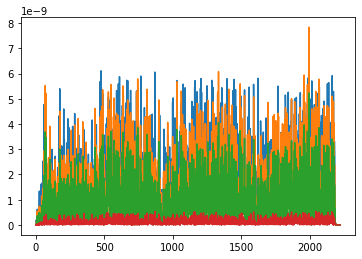

2223


In [7]:
hashed = np.zeros(shape=sampled.shape[0], dtype=np.int64)
unique = []

for i in range(0, sampled.shape[0]):
    for frq in range(40, 300):
        magnitude = np.log(np.abs(sampled[i][frq])+1)
#         print(np.log2(np.abs(sampled[i][frq])+1))
        range_index = get_range_of_frequency(frq)
#         print("magnitude: ", magnitude)
#         print("highest: ", highest[i][range_index])

        if magnitude > highest[i][range_index]:
            highest[i][range_index] = frq
            magnitude = magnitude.astype(float)
            values[i][range_index] = magnitude
            peaks[i][range_index] = point_position(magnitude)

    hashed[i] = fingerprint_hash(peaks[i][1], peaks[i][2], peaks[i][3], peaks[i][4])
    unique.append((values[i][1], values[i][2], values[i][3], values[i][4]))
# plt.hist(hashed)
print(len(list(set(unique))))
plt.plot(unique)
plt.show()
print(len(hashed))
# for i in range(len(hashed)):
#     print(hashed[i])